# Basic Concepts of Radiometry

We need to establish and clarify some basic concepts of Radiometry before we proceed further. 

While we will show some coding examples, these mechanics are mostly buried in the `Light` and `LightSource` objects. See [this notebook](light.ipynb) to see these objects in action.

As the basic terminology, Exitance is the power "exiting" per unit emitter area. Irradiance (or Illuminance in Photometry) is the "incoming" power per unit "illuminated" surface area. These are measured in Watt/m<sup>2</sup> and they correspond to the flux perpendicular to an area (either on the source or on the receiver). Radiance (or Luminance in Photometry) has an additional directional quality and is measured in Watt/m<sup>2</sup>/sr.

The notation here closely follows the one defined in [Wikipedia](https://en.wikipedia.org/wiki/Irradiance#SI_radiometry_units).

We have to start with the opticks package import as well as some other useful packages.

In [132]:
# If opticks import fails, try to locate the module
# This can happen building the docs
import os

try:
    import opticks
except ModuleNotFoundError:
    os.chdir(os.path.join("..", "..", ".."))
    os.getcwd()

In [133]:
import numpy as np
import portion as P

from opticks import u, Q_

%matplotlib inline

# pint support to matplotlib
u.setup_matplotlib()

import warnings

warnings.filterwarnings("always")

## Spectral Radiance: The Spectrum of the Radiated Power on the Emitter Surface

A simple example is the [Planck's Law](https://en.wikipedia.org/wiki/Planck's_law), that describes a spherically uniform radiated power, which is the function of the wavelength and the surface temperature only. 

$$ L_\lambda = 
    \frac{2 h c^2}{\lambda^5}
    \frac{1}{e^{hc / \lambda k T} - 1}
$$

The unit is $W/(sr. m^2 . nm)$, meaning that the [Spectral Radiance](https://en.wikipedia.org/wiki/Spectral_radiance) defined: 
1. represents the power output, 
2. from a unit [solid angle](https://en.wikipedia.org/wiki/Solid_angle) (given in steradians) on the emitter,
3. for each unit wavelength (the $nm$ part),
4. impinging on a target surface at a distance and normal to the radiation vector with a unit area (the $m^2$ part).

As an example, we can illustrate modelling the Sun as a 5778 K blackbody.

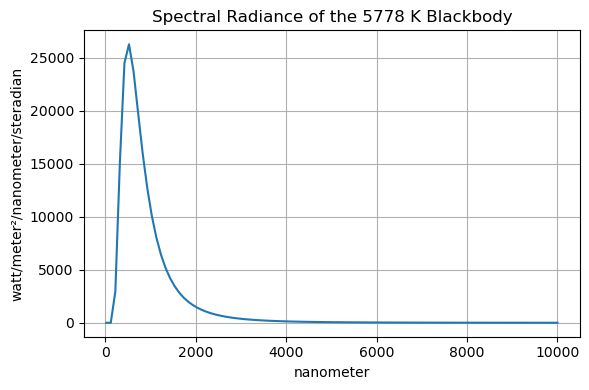

In [134]:
from opticks.utils.interval_data import (
    FunctCombinationMethod,
    IntervalData,
    IntervalDataPlot,
)
from opticks.utils.math_utils import InterpolatorWithUnits, InterpolatorWithUnitTypes

# setup
# ****************************
begin = 20 * u.nm
end = 10000 * u.nm

wvl_range = P.closed(begin, end)

sample_size = 8000

T = 5778 * u.K

# generate the spectral radiance data
# ****************************

# generate wavelength values
wvl = np.linspace(wvl_range.lower, wvl_range.upper, num=sample_size, endpoint=True)

c = (1 * u.speed_of_light).to("m/s")
k_B = (1 * u.boltzmann_constant).to("J/K")
h = (1 * u.planck_constant).to("J.s")

# spectral radiance (L_wvl): Planck's law of blackbody radiation
top = 2 * h * c**2 / wvl**5
bottom = np.exp(h * c / (wvl * k_B * T)) - 1
spec_radiance = (top / bottom).to("W/(m^2 . sr. nm)")

spec_radiance_model = InterpolatorWithUnits.from_ipol_method(
    InterpolatorWithUnitTypes.AKIMA, wvl, spec_radiance, extrapolate=True
)

full_spectrum_radiance = IntervalData({wvl_range: spec_radiance_model})

# generate the plot
plot = full_spectrum_radiance.plot()

plot.set_plot_style(title=f"Spectral Radiance of the {T:~P} Blackbody", legend_off=True)

## Spectral Irradiance: Flux Density on the Target Surface

The Spectral Radiance defined in the previous section described the power output of a small (differential) solid angle surface on the emitter, but didn't quite explain how to calculate the flux at a distance. Flux in this context means the component of the power radiated by the blackbody impinging vertically on a unit area target surface. Spectral Irradiance therefore starts from Spectral Radiance and then computes the geometric shape of the emitter (or more generally the Wavefront) and the "rays" out of emitting surfaces to compute the flux out of this emitter. 

The first part is to compute how much of the blackbody the the target surface "sees". The easy answer is just one half of the spherical radiation, or $2\pi$ steradians of solid angle.

The more proper (or general) explanation requires thinking a bit in terms of the geometry of the problem. An arbitrary solid angle is given by the double integral:

$$ \int d\omega = \int \int \sin \theta d\theta d\varphi $$

where $\theta$ is the colatitude (angle from the North Pole) and $\varphi$ is the longitude. The definite integral is straightforward.

$$ \int_{\theta_0}^{\theta_1} \int_{\varphi_0}^{\varphi_1} \sin \theta d\theta d\varphi = \left( -\cos\theta_1 - \cos\theta_0 \right) . (\varphi_1 - \varphi_0)$$

As the target surface sees only one hemisphere, the longitude $\varphi$ is defined from 0 to 360 degrees, and the colatitude $\theta$ is defined from 0 to 90 degrees. Plugging the values (in radians), we can see that the solid angle is indeed $2\pi$ steradians.

In [135]:
# 4 pi steradian is the full sphere
# phi 0 to 2pi
# th 0 to pi

# for the generic definition
phi1 = (360 * u.deg).to(u.rad)
phi0 = (0 * u.deg).to(u.rad)

th1 = (90 * u.deg).to(u.rad)
th0 = (0 * u.deg).to(u.rad)

solid_angle = (phi1 - phi0) * (-(np.cos(th1) - np.cos(th0)) * u.rad)

print(
    f"Solid angle: {solid_angle.to(u.sr):~P} ({solid_angle.m_as(u.rad) / np.pi} x pi)"
)

Solid angle: 6.283185307179585 sr (1.9999999999999998 x pi)


However, the flux definition requires us to compute the normal components of the spectral radiance for each small (or differential) emitting area, which adds a $\cos\theta$ to the integral:

$$ \int \cos\theta d\omega = \int \int \cos \theta \sin \theta d\theta d\varphi $$

The solution requires one intermediate step ($u=\sin\theta$ substitution) but is still not terribly difficult.

$$ \int_{\theta_0}^{\theta_1} \int_{\varphi_0}^{\varphi_1} \cos \theta \sin \theta d\theta d\varphi = \frac{1}{2} \left( \sin^2\theta_1 - \sin^2\theta_0 \right) . (\varphi_1 - \varphi_0)$$


In [136]:
phi1 = (360 * u.deg).to(u.rad)
phi0 = (0 * u.deg).to(u.rad)

th1 = (90 * u.deg).to(u.rad)
th0 = (0 * u.deg).to(u.rad)

flux_coeff = (phi1 - phi0) * 1 / 2 * (np.sin(th1) ** 2 - np.sin(th0) ** 2) * u.rad

print(
    f"Geometric coefficient for the flux: {flux_coeff.to(u.sr):~P} ({flux_coeff.m_as(u.rad) / np.pi} x pi)"
)

Geometric coefficient for the flux: 3.141592653589793 sr (1.0 x pi)


Spectral Irradiance or Spectral Flux Density is therefore:

$$E_\lambda = \int L_\lambda \cos \theta d\omega = L_\lambda \int  \cos \theta d\omega$$

where the integral is essentially the "geometric flux coefficient" computed above. 

Summarising, the Spectral Irradiance, or the power through the unit area per unit wavelength (of the blackbody) is:

$$ E_\lambda = \pi L_\lambda = 
    \frac{2 h \pi c^2}{\lambda^5}
    \frac{1}{e^{hc / \lambda k T} - 1}
$$

where the unit is W/m<sup>2</sup>/nm.

More generally, the $ E_\lambda = \pi L_\lambda$ equation holds for all Lambertian emitters (see [Lambert's Cosine Law](https://en.wikipedia.org/wiki/Lambert%27s_cosine_law)).

Finally, we can plot the Spectral Irradiance curve.

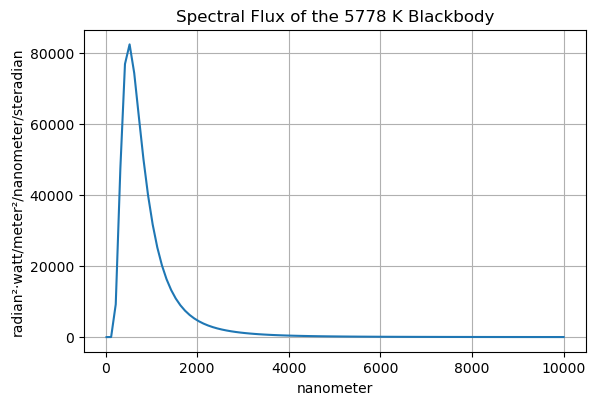

In [137]:
spec_flux = full_spectrum_radiance.scale(flux_coeff)

# generate the plot

plot = IntervalDataPlot({"spec_flux": spec_flux}, apply_default_style=False)

plot.set_plot_style(title=f"Spectral Flux of the {T:~P} Blackbody", legend_off=True)

## Radiant and Spectral Exitance: Power Output of a Source

The Spectral Irradiance (or Spectral Flux Density) defined above can be seen as the power output out of an emitting body (or Spectral Exitance). In this example, as we set up the source as a blackbody, we can compute the Exitance and check it against the theory.

The Radiant Exitance of a blackbody is given as $\sigma T^4$, which is the integration of the power in all wavelengths. Therefore, we can equally integrate the Spectral Irradiance.

In [138]:
# Stefan-Boltzmann constant
s = (1 * u.stefan_boltzmann_constant).to("W.m^-2. K^-4")

# radiant exitance: M = s.T**4
M = s * T**4

print(M)

print(spec_flux.integrate().to("W/m^2"))

63200699.736845456 watt / meter ** 2
63118559.75767138 watt / meter ** 2


The (small) difference is due to the limited wavelength of the Spectral Irradiance definition above.

## Radiant Power, Total Flux and Flux at a Distance

We can now define the propagation of light in free space. In this example, the surface of the Sun is the blackbody and we can compute the flux at the Earth.

First we compute the Radiant Power on the surface of the blackbody sphere. This Radiant Power is also called Luminosity or, in this case,the Solar Luminosity.

3.83893670158252e+26 watt


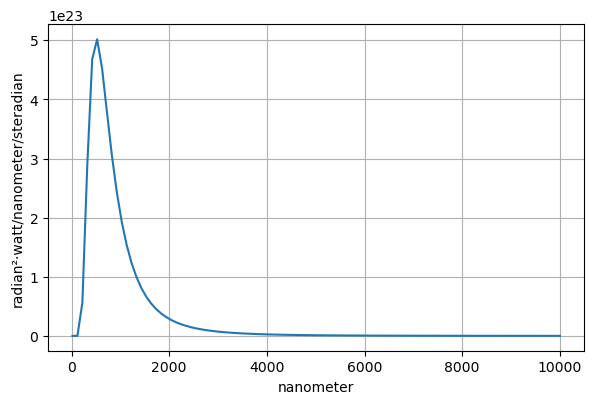

In [139]:
r_sun = (695700 * u.km).to(u.m)

# area of the sphere
area_sphere = 4 * np.pi * r_sun**2

total_spectral_power = spec_flux.scale(area_sphere)

print(total_spectral_power.integrate().to("W"))

# flux at the surface of the sun
total_spectral_power.plot()

The same power reaches the Earth distance, though now the radius of the sphere is the size of 1 AU or about 150 million km.

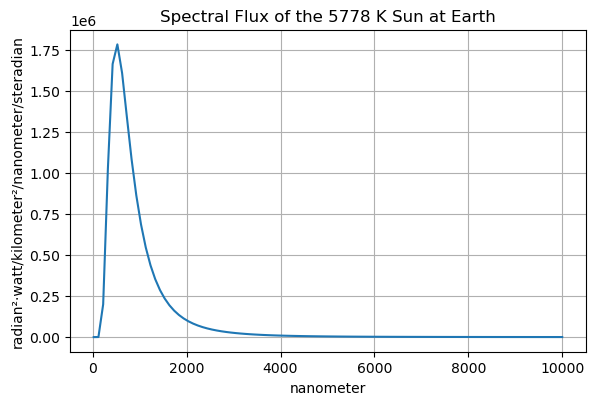

In [140]:
# propagate in free space towards the Earth ToA
distance = (1 * u.au).to(u.km)

# area of the sphere
area_sphere = 4 * np.pi * distance**2

spec_flux_at_earth = total_spectral_power.scale(1 / area_sphere)


# generate the plot
plot = IntervalDataPlot(
    {"spec_flux_at_earth": spec_flux_at_earth}, apply_default_style=False
)

plot.set_plot_style(title=f"Spectral Flux of the {T:~P} Sun at Earth", legend_off=True)

We can integrate over the wavelengths to compute the total flux. The true value is around 1366 W/m<sup>2</sup>.

This is called the [Irradiance or Flux Density](https://en.wikipedia.org/wiki/Flux_density).

In [141]:
spec_flux_at_earth.integrate().to("W/m^2")

<Quantity(1365.05536, 'watt / meter ** 2')>